# Getting started: Maximum Logit Score on MNIST

This notebook aims at introducing the core features of `oodeel`, including :
* Instantiation of `OODDataset` to load a dataset from `tensorflow_datasets` or `torchvision.datasets` catalog and to organize in-distribution and out-of-distribution data.
* Preparation of a `tf.data.Dataset` or a `torch.DataLoader` ready for scoring and/or training.
* A simple utils to train neural nets (adapted when in-distribution is not a standard dataset, such as a subset of class from a dataset)
* Instantiation of `OODBaseDetector` based on an already trained model, that is used for scoring data.
* Some evaluation metrics to assess the quality of OOD detection.

First, some required imports.

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output

from oodeel.methods import MLS
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores
from oodeel.datasets import load_data_handler
from oodeel.utils.tf_training_tools import train_tf_model
from oodeel.utils.torch_training_tools import train_torch_model

from sklearn.metrics import accuracy_score, roc_auc_score

import warnings

warnings.filterwarnings("ignore")

cuda_idx = 0 if torch.cuda.is_available() else None

clear_output()

Models are saved at *~/.oodeel/saved_models* and data is supposed to be found
at *~/.oodeel/datasets* by default. Change the following cell for a custom path.

In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## MNIST vs Fashion MNIST

* In-distribution data: MNIST 
* Out-of-distribution data: Fashion MNIST

### Load and prepare the datasets

This is performed using the class `OODDataset`. First, load the datasets.

Before loading, choose your backend (tensorflow or torch). You only have to give it as input to `OODDataset` and that's it. The rest of the code will be exactly the same regardless of the library (except for model loading).

When a `str` is given as argument, `OODDataset` will automatically search in the `tensorflow_datasets` or `torchision.datasets` catalogs. Be careful with the `str` you give as input, it has to exactly match the name of the dataset in `tensorflow_datasets` or `torchision.datasets` (and it is case-sensitive). 

<div class="admonition tip">
  <p class="admonition-title">Loading from existing data objects</p>
  <p>
    In this notebook, the datasets are loaded from platforms, but you can also instanciate OODDataset with your own tf.data.Dataset, tf.Tensor, torch.Dataset or np.arrays
  </p>
</div>

> **Warning**
>
>*  We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD) data with `_out` to avoid confusion with OOD detection which is the name of the task, and is therefore used to denote core classes such as `OODDataset` and `OODBaseDetector`.
>*  When loading from `tensorflow_datasets` or `torchision.datasets`, do not forget to check which `load_kwargs` to add. It can change for different datasets, even withing a same platform. 


In pytorch from `torchision.datasets` catalog:

In [3]:
backend = "torch"
data_handler = load_data_handler(backend)

ds_in = data_handler.load_dataset(
    "MNIST",
    load_kwargs={"train": False, "root": data_path, "download": True},
)
ds_out = data_handler.load_dataset(
    "FashionMNIST",
    load_kwargs={"train": False, "root": data_path, "download": True},
)
ds_train = data_handler.load_dataset(
    "MNIST",
    load_kwargs={"train": True, "root": data_path, "download": True},
)


def preprocess_fn(inputs):
    inputs["input"] = inputs["input"].float() / 255.0
    return inputs

In tensorflow from `tensorflow_datasets` catalog:

In [4]:
backend = "tensorflow"
data_handler = load_data_handler(backend)

ds_in = data_handler.load_dataset(
    "mnist",
    load_kwargs={"split": "test"},
)
ds_out = data_handler.load_dataset(
    "fashion_mnist",
    load_kwargs={"split": "test"},
)
ds_train = data_handler.load_dataset(
    "mnist",
    load_kwargs={"split": "train"},
)


def preprocess_fn(inputs):
    inputs["image"] /= 255
    return inputs

> **Note**
>
> When backend is "torch", the datasets can still be loaded from `tensorflow_datasets`, and are converted on the fly and loaded on VRAM as torch tensors. This feature can be useful because tensorflow_datasets's catalog is way larger than torchvision dataset's. In that case, however, the loaded dataset cannot be used for training with `train_torch_model`.

Then, prepare the dataset for scoring and/or training using `.prepare` method.

In [5]:
batch_size = 128

ds_in = data_handler.prepare(
    ds_in,
    batch_size=batch_size,
    preprocess_fn=preprocess_fn,
    columns=["image", "label"],
)
ds_out = data_handler.prepare(
    ds_out,
    batch_size=batch_size,
    preprocess_fn=preprocess_fn,
    columns=["image", "label"],
)
ds_train = data_handler.prepare(
    ds_train,
    batch_size=batch_size,
    preprocess_fn=preprocess_fn,
    columns=["image", "label"],
    shuffle=True,
)

`ds_in`, `ds_out` and `ds_train` are regular `tf.data.Dataset`or `torch.DataLoader` that you can use like usual!  

Train or load a model on in-distribution data (MNIST).

... a keras model if `backend="tensorflow"`... or a pytorch one, if `backend="torch"`.

In [6]:
model_path_mnist = os.path.join(model_path, "mnist_model_tensorflow.h5")

try:
    model_tf = tf.keras.models.load_model(model_path_mnist)
except OSError:
    train_config = {
        "model": "toy_convnet",
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in,  # ds_in is actually the test set of MNIST
    }

    model_tf = train_tf_model(ds_train, **train_config)

... or a pytorch one, if `backend="torch"`

In [7]:
model_path_mnist = os.path.join(model_path, "mnist_model_torch")
try:
    model_torch = torch.load(os.path.join(model_path_mnist, "best.pt"))
except OSError:
    train_config = {
        "model": "toy_convnet",
        "num_classes": 10,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in,  # ds_in is actually the test set of MNIST
        "cuda_idx": cuda_idx,
    }
    model_torch = train_torch_model(ds_train, **train_config)

### Maximum Logit Score (MLS)

Return an OOD score based on the maximum value of the output logits. Introduced in [Open-Set Recognition: a Good Closed-Set Classifier is All You Need?](http://arxiv.org/abs/2110.06207), ICLR 2022.

In this section, we use `model_tf` because `backend="tensorflow"`

In [8]:
if backend == "tensorflow":
    model = model_tf
elif backend == "torch":
    model = model_torch

Simply fit the `OODBaseDetector` to the model and then score the dataset.

In [9]:
mls = MLS()

mls.fit(model)
scores_in, _ = mls.score(ds_in)
scores_out, _ = mls.score(ds_out)

>   Tip
>
>   You can also obtain the prediction of the underlying model using the `.score` method. Just name a 
>   variable instead of `_`. For instance, in `scores_in, info_in = mls.score(ds_in)`, info_in is a dict 
>   containing the predictions of the model from ds_in, and the labels if they are found in ds_in. Here, we use `_` because we do not need the predictions.

Compute the evaluation metrics based on the scores of the test data, and visualize the scores histogram.

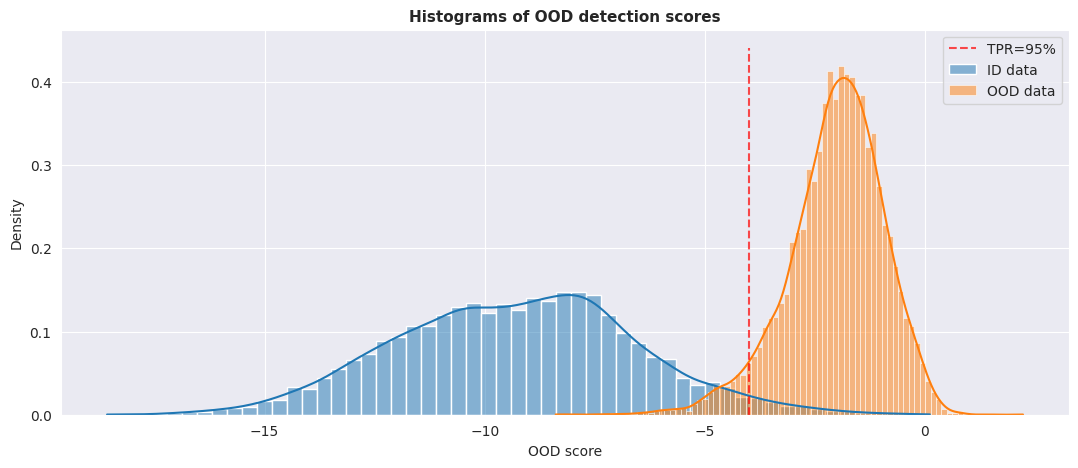

auroc             0.99227
fpr95tpr          0.02770
accuracy_score    0.87315
dtype: float64


In [10]:
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr", accuracy_score],
    threshold=-7.5,  # visually chosen based on the plot
)

plt.figure(figsize=(13, 5))
plot_ood_scores(scores_in, scores_out)
plt.show()
metrics = pd.Series(metrics)
print(metrics)

### Maximum Softmax Probability (MSP)

It is possible to do the same after the softmax activation. Introduced in [A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks](http://arxiv.org/abs/1610.02136), ICLR 2017.

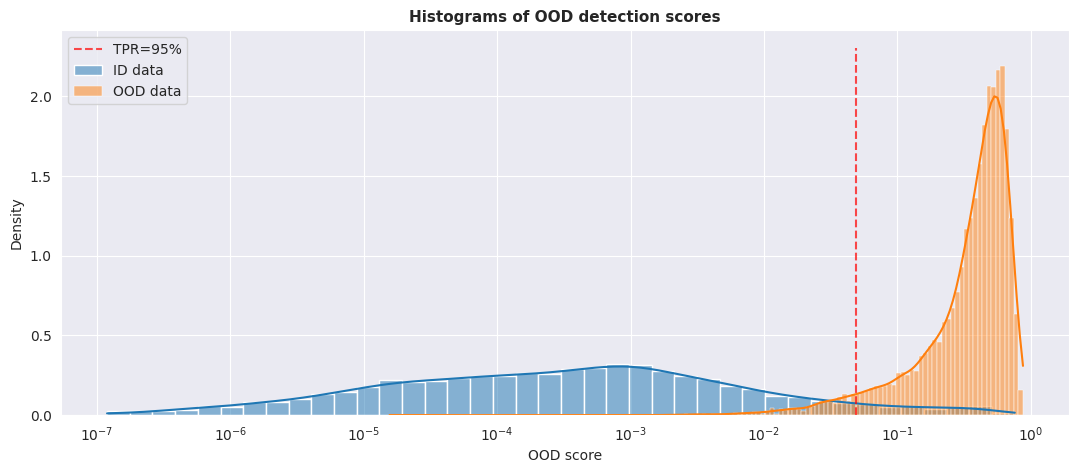

auroc             0.985025
fpr95tpr          0.057000
accuracy_score    0.946000
roc_auc_score     0.985024
dtype: float64


In [11]:
msp = MLS(output_activation="softmax")
msp.fit(model)
scores_in, _ = msp.score(ds_in)
scores_out, _ = msp.score(ds_out)

metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr", accuracy_score, roc_auc_score],
    threshold=-0.95,  # visually chosen based on the plot
)

# Normalize scores for a better hist visualization
minim = np.min([np.min(scores_in), np.min(scores_out)])
scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])

plt.figure(figsize=(13, 5))
plot_ood_scores(scores_in_, scores_out_, log_scale=True)
plt.show()
metrics = pd.Series(metrics)
print(metrics)

## MNIST (0-4) vs MNIST (5-9)

* In-distribution data: MNIST (0-4)
* Out-of-distribution data: MNIST (5-9)

We can repeat the procedure in an open-set-recognition or semantic OOD setting by considering a subset of MNIST classes as in-distribution and another subset as out-of-distribution. The datasets are constructed using the `OODDataset` method `.split_by_class`. First load and split the dataset.

In Pytorch:

In [19]:
backend = "torch"
data_handler = load_data_handler(backend)

ds_test = data_handler.load_dataset(
    "MNIST",
    load_kwargs={"train": True, "root": data_path, "download": True},
)
ds_train = data_handler.load_dataset(
    "MNIST",
    load_kwargs={"train": False, "root": data_path, "download": True},
)


def preprocess_fn(inputs):
    inputs["input"] = inputs["input"].float() / 255.0
    return inputs

or in Tensorflow

In [20]:
backend = "tensorflow"
data_handler = load_data_handler(backend)

ds_test = data_handler.load_dataset(
    "mnist",
    load_kwargs={"split": "test"},
)
ds_train = data_handler.load_dataset(
    "mnist",
    load_kwargs={"split": "train"},
)


def preprocess_fn(inputs):
    inputs["image"] /= 255
    return inputs


clear_output()

Then prepare the datasets for scoring and/or training.

In [21]:
batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
ds_train, _ = data_handler.split_by_class(ds_train, in_labels=inc_labels)
ds_in, ds_out = data_handler.split_by_class(ds_test, in_labels=inc_labels)



ds_train = data_handler.prepare(
    ds_train,
    batch_size=batch_size,
    preprocess_fn=preprocess_fn,
    shuffle=True,
    columns=["image", "label"],
)
ds_in = data_handler.prepare(
    ds_in,
    batch_size=batch_size,
    preprocess_fn=preprocess_fn,
    columns=["image", "label"],
)
ds_out = data_handler.prepare(
    ds_out,
    batch_size=batch_size,
    preprocess_fn=preprocess_fn,
    columns=["image", "label"],
)

Train or load the model.

In Tensorflow:

In [22]:
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4.h5")

try:
    model_tf = tf.keras.models.load_model(model_path_mnist_04)
except OSError:
    train_config = {
        "model": "toy_convnet",
        "input_shape": (28, 28, 1),
        "num_classes": 5,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in,  # ds_in is actually the test set of MNIST
    }

    model_tf = train_tf_model(ds_train, **train_config)

In Pytorch:

In [23]:
model_path_mnist = os.path.join(model_path, "mnist_model_torch_0-4")
try:
    model_torch = torch.load(os.path.join(model_path_mnist, "best.pt"))
except OSError:
    train_config = {
        "model": "toy_convnet",
        "num_classes": 5,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in,  # ds_in is actually the test set of MNIST
        "cuda_idx": cuda_idx,
    }
    model_torch = train_torch_model(ds_train, **train_config)

### Maximum Logit Score (MLS)

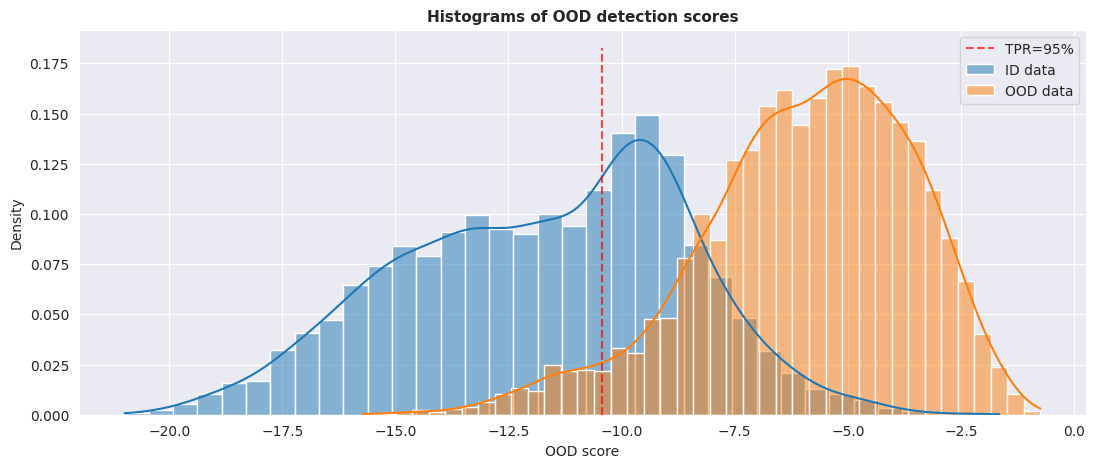

auroc             0.931308
fpr95tpr          0.403775
accuracy_score    0.851600
roc_auc_score     0.931308
dtype: float64


In [24]:
if backend == "tensorflow":
    model = model_tf
elif backend == "torch":
    model = model_torch

mls = MLS()
mls.fit(model)
scores_in, _ = mls.score(ds_in)
scores_out, _ = mls.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr", accuracy_score, roc_auc_score],
    threshold=-7.5,  # visually chosen based on the plot
)

plt.figure(figsize=(13, 5))
plot_ood_scores(scores_in, scores_out)
plt.show()
metrics = pd.Series(metrics)
print(metrics)

### Maximum Softmax Probability (MSP)

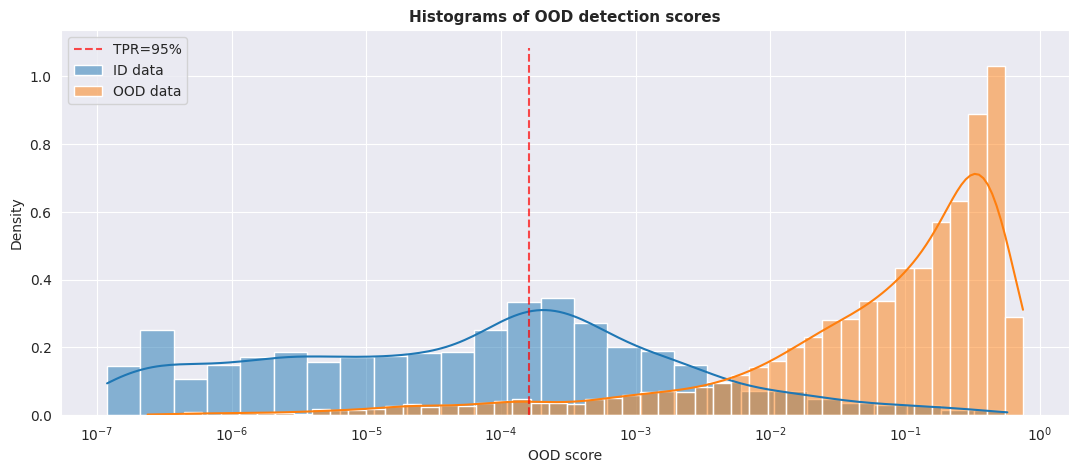

auroc             0.938834
fpr95tpr          0.416813
accuracy_score    0.819200
roc_auc_score     0.938834
dtype: float64


In [25]:
msp = MLS(output_activation="softmax")
msp.fit(model)
scores_in, _ = msp.score(ds_in)
scores_out, _ = msp.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr", accuracy_score, roc_auc_score],
    threshold=-0.95,  # visually chosen based on the plot
)

# Normalize scores for a better hist visualization
minim = np.min([np.min(scores_in), np.min(scores_out)])
scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])

plt.figure(figsize=(13, 5))
plot_ood_scores(scores_in_, scores_out_, log_scale=True)
plt.show()
metrics = pd.Series(metrics)
print(metrics)